## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. It is important that you get some practice working with the difficulties of these 

<a id='probability'></a>
#### Part I - Probability

In [29]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [30]:
df = pd.read_csv('ab_data.csv')

In [31]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [32]:
len(df)

294478

c. The number of unique users in the dataset.

In [33]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [34]:
df[df.converted.astype(bool)].user_id.nunique()/df.user_id.nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [35]:
not_aligned = np.logical_xor(df.group=='treatment', df.landing_page=='new_page')
not_aligned.sum()

3893

f. Do any of the rows have missing values?

In [36]:
df.isnull().sum().sum()

0

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [37]:
df2 = df[~not_aligned]

In [38]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [39]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [40]:
repeat_user = int(df2.user_id[df2.user_id.duplicated()])
repeat_user

773192

c. What is the row information for the repeat **user_id**? 

In [41]:
rep_user_df = df2[df2.user_id==repeat_user]
rep_user_df

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [42]:
df2 = df2.drop(rep_user_df.index[0])
df2 = df2.reindex()

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [43]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [44]:
control_rate = df2[df2.group=='control'].converted.mean()
control_rate 

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [45]:
treatment_rate = df2[df2.group=='treatment'].converted.mean()
treatment_rate

0.11880806551510564

d. What is the probability that an individual received the new page?

In [46]:
(df2.landing_page=='new_page').mean()

0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

We have two groups, almost equal in size. the probabilities for both control and treatment groups are very close and it's hard to tell whether one page really leads to more conversions. The numbers are similar even in absolute values (not to mention the proportions we've checked): 

In [47]:
print("Control: " + str(df2[df2.group=='control'].converted.sum()) 
      + " out of " + str(len(df2[df2.group=='control'])))
print("Treatment: " + str(df2[df2.group=='treatment'].converted.sum()) 
      + " out of " + str(len(df2[df2.group=='treatment'])))

Control: 17489 out of 145274
Treatment: 17264 out of 145310


We need to perform hypothesis testing in order to verify our results and have more confidence in saying if there is difference in the converstion rate. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} \leq p_{old}$$
$$H_1: p_{new} > p_{old}$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [48]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [49]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [50]:
n_new = (df2.group=='treatment').sum()
n_new

145310

d. What is $n_{old}$?

In [51]:
n_old = (df2.group=='control').sum()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [52]:
np.random.seed(1)
new_page_converted = df2.converted.sample(n_new)
new_page_converted.mean()

0.12092079003509738

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [53]:
old_page_converted = df2.converted.sample(n_old)
old_page_converted.mean()

0.119684182992139

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [54]:
new_page_converted.mean() - old_page_converted.mean()

0.0012366070429583875

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [55]:
p_diffs = []
for _ in range(10000):
    # taking the same data frame to take samples, because we assume the same rate by task requirement
    new_page_mean = df2.converted.sample(n_new, replace=True).mean()
    old_page_mean = df2.converted.sample(n_old, replace=True).mean()
    p_diffs.append(new_page_mean-old_page_mean) 

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

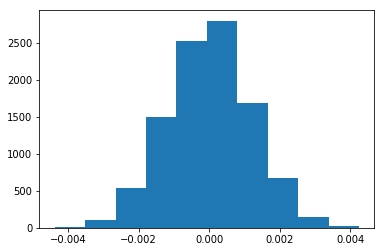

In [56]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [57]:
actual_diff = treatment_rate-control_rate
(p_diffs > actual_diff).mean()

0.9085

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:**

We've calculated the p-value as it is the % of the simulated data above the threshold. At the same time, it's also the probability that our data is from null-hypothesis distribution. The p-values is big (well above 0.05), so we fail to reject the null-hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [59]:
import statsmodels.api as sm

convert_old = df2[(df2.landing_page=='old_page')].converted.sum()
convert_new = df2[(df2.landing_page=='new_page')].converted.sum()
n_old = df2[(df2.landing_page=='old_page')].user_id.nunique()
n_new = df2[(df2.landing_page=='new_page')].user_id.nunique()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [61]:
# one-tailed test
# smaller means that the alternative hypothesis is prop < value
z_stat, p_value = sm.stats.proportions_ztest([convert_old, convert_new], 
                                             [n_old, n_new], 
                                             alternative='smaller', value=0)
print(z_stat)
print(p_value)

1.3109241984234394
0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer:**.   
The provided link for stats.proportions_ztest doesn't work and I used official documentation only. As I understand, the way to perform analogous procedure is to run a two-sample test and compare the difference between the proportions to some value (in this case - 0). So in terms of function parameters we can have the same hypotheses by setting the alternative to 'smaller':

$$H_0: \frac{\text{converted_old}}{\text{n_old}} - \frac{\text{converted_new}}{\text{n_new}} \geq \text{value}$$

$$H_1: \frac{\text{converted_old}}{\text{n_old}} - \frac{\text{converted_new}}{\text{n_new}} < \text{value}$$



According to the <a href="http://users.stat.ufl.edu/~athienit/Tables/Ztable.pdf">z-table</a> the p-value, the area under that curve, describing our p-value, is 0.9049, which almost perfectly matches the p-value that the function returns.  
Also, the p-value is similar to what we obtained by manual calculation in the previous section - about 0.91.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer:**  

Logistic regression, because we are interested in categorical output - yes/no, 1/0.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [62]:
df3 = df2.copy()
df3['ab_page'] = (df2.group=='treatment').astype(int)
df3['intercept'] = 1
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [63]:
log_mod = sm.Logit(df3['converted'], df3[['intercept','ab_page']])
result = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [64]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 02 Mar 2019   Pseudo R-squ.:               8.077e-06
Time:                        22:02:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?
The p-value for the ab_page is 0.190 which is well above 

<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Answer.**  

The p-value is **0.190** which is different from 0.9, but we're a testing a different thing here. Our null-hypothesis is that the coefficient for ab_page is 0. The alternative hypothesis is that it's different (in any direction - either smaller or larger). We're looking at the area outside of the confidence interval. So that would be an equivalent of a two-tailed test, which can be performed as follows: 

In [65]:
z_stat, p_value = sm.stats.proportions_ztest([convert_old, convert_new], 
                                             [n_old, n_new], 
                                             alternative='two-sided', value=0)
print(z_stat)
print(p_value)

1.3109241984234394
0.18988337448195103


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:**  
Adding other variables can provide additional information and make our predictions more accurate. However, more variables are not necessaritly better. One potential problem with having more variables is correlation between these variable that will make coefficient and p-values innacurate. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [66]:
countries = pd.read_csv('./countries.csv')

In [67]:
df4 = pd.merge(df3, countries, how='inner', left_on='user_id', right_on='user_id')
df4[['CA','UK','US']] = pd.get_dummies(df4.country)

In [68]:
df4.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,1


We can check for multicollinearity by calculating variance inflaction factor. In general, if it's above 5, then it's a sign of collinearity. 

In [69]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
features = ['intercept','ab_page','CA','UK']
X = df4[features]
vifs = pd.DataFrame({'feature': features,'VIF': [variance_inflation_factor(X.values, i) for i in range(len(features))]})
vifs

,feature,VIF
0,intercept,2.428940
1,ab_page,1.000006
2,CA,1.017759
3,UK,1.017761


So, we're okay with this selection of features. It's also interesting to note that if we add the third country, our VIF will just blow up - to infinity! Also we can illustrate why we need to remove one column with the country while having an intercept. We want the matrix rank to be equal to the number of columns. However, if we don't remove one variable we will have a rank equal to number of columns - 1. So we will pass 5 columns and calculate the rank: 

In [70]:
np.linalg.matrix_rank(df4[['intercept','ab_page','CA','UK','US']])

4

That's why we need to get rid of one countries: 

In [71]:
np.linalg.matrix_rank(df4[['intercept','ab_page','CA','UK']])

4

In [72]:
log_mod2 = sm.Logit(df4['converted'], df4[['intercept','ab_page','CA','UK']])
result2 = log_mod2.fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 02 Mar 2019   Pseudo R-squ.:               2.323e-05
Time:                        22:02:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

**Summary:**.  
Based on the results, we can say that all the coefficients have little influence on the outcome and we fail to reject the null-hypotheses that these coefficients are zero.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [73]:
df4['ab_page_UK'] = df4['ab_page']*df4['UK']

In [74]:
df4['ab_page_CA'] = df4['ab_page']*df4['CA']

In [75]:
log_mod2 = sm.Logit(df4['converted'], df4[['intercept','ab_page','CA','UK','ab_page_UK', 'ab_page_CA']])
result2 = log_mod2.fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 02 Mar 2019   Pseudo R-squ.:               3.482e-05
Time:                        22:03:01   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_page_UK     0.0314      0.027      1.181      0.238      -0.021       0.084
ab_page_CA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
==============================================================================
"""

**Results**:  
Even after adding interaction terms, it didn't improve our model a bit, and we still have all the p-value well above 0.05, so we don't have any evidence that any of our variables are significant to predict whether the customer will convert. 

### Does conversion depend on weekday? 

In [76]:
# extract weekdays and shift by one so that 1 is Monday, 7 is Sunday
df4['weekday'] = pd.to_datetime(df4.timestamp).apply(lambda x: x.dayofweek)+1

In [77]:
df4[["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday", "Sunday"]] = pd.get_dummies(df4.weekday)

In [78]:
log_mod3 = sm.Logit(df4['converted'], df4[['intercept',
                                           "Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]])
result3 = log_mod3.fit()
result3.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290577
Method:                           MLE   Df Model:                            6
Date:                Sat, 02 Mar 2019   Pseudo R-squ.:               2.601e-05
Time:                        22:03:07   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.4773
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0069      0.015   -129.579      0.000      -2.037      -1.977
Monday         0.0254      0.021      1.200      0.230      -0.016       0.067
Tuesday        0.0101      0.021      0.482      0.630      -0.031       0.051
Wednesday      0.0177      0.022      0.807      0.420      -0.025       0.061
Thursday       0.0141      0.022      0.644      0.519      -0.029       0.057
Friday        -0.0172      0.022     -0.782      0.434      -0.060       0.026
Saturday       0.0223      0.022      1.019      0.308      -0.021       0.065
==============================================================================
"""

**Results:** 
Still, the p-values tell us that the weekday is not significant for predicting conversion.     

### Does the time of the day matter? 

Here I wanted to try to create yet another artificial variable - time of the day. I'm going to split the day into four parts: morning, day, evening and night and use the the night as the baseline. 

In [79]:
df4['hour'] = pd.to_datetime(df4.timestamp).apply(lambda x: x.hour)

In [80]:
df4['morning'] = ((df4.hour > 7) & (df4.hour <= 11)).astype(int)
df4['day'] = ((df4.hour > 11) & (df4.hour <= 18)).astype(int)
df4['evening'] = ((df4.hour > 18) & (df4.hour <= 23)).astype(int)

In [81]:
log_mod4 = sm.Logit(df4['converted'], df4[['intercept',
                                           'morning','day','evening']])
result4 = log_mod4.fit()
result4.summary()

Optimization terminated successfully.
         Current function value: 0.366105
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 02 Mar 2019   Pseudo R-squ.:               4.557e-05
Time:                        22:03:11   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.02134
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0208      0.010   -202.135      0.000      -2.040      -2.001
morning        0.0378      0.017      2.201      0.028       0.004       0.071
day            0.0416      0.015      2.870      0.004       0.013       0.070
evening        0.0286      0.016      1.785      0.074      -0.003       0.060
==============================================================================
"""

**Results:**


And we finally have some results! **TWO** variable with p-values less than 0.05: morning and day. It means that it's not likely that the coefficient for these variables are 0, so they are significant for prediction whether the user will convert. So for day we expect increase in log-odds by ${0.0416}$ compared to night and holding other variables costant. For morning we expcect increase in log-odds by $0.0378$ compared to night and holding other variables constant. 

In [83]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Website_AB_Testing.ipynb'])

0